## Training of the neural network for the X-ray reconstruction

In the following notebook, an hexsample simulation will be extracted, preprocessed and used for training a neural network for inferring the X-ray energy and its hit position.

In [91]:
import os

import numpy as np

# importing the necessary keras modules for model creation, training and saving
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from matplotlib import pyplot as plt

In [2]:
# importing the custom libraries
from xrayreco.preprocessing import Xraydata

In [3]:
# Loading an hexsample simulation and storing its content into an Xraydata object
file_path = '/Users/chiara/hexsampledata/hxsim.h5'
data = Xraydata(file_path)

>>> Opening input file /Users/chiara/hexsampledata/hxsim.h5...
>>> File type: FileType.DIGI


In [4]:
# The Xraydata object contains methods for preprocessing that give the input and training output for the NN
input_data = data.input_events_data()
# Obtaining training output data from MC truth
target_data = data.target_data()

0it [00:00, ?it/s]

1000000it [00:32, 30502.23it/s]


In [5]:
# Printing the input data of the first event and the shape of the overall input
print(input_data[1])
print(input_data.shape)

[[ 1.77400000e+03 -3.62500000e-02  1.08253175e-02]
 [ 4.16000000e+02 -3.37500000e-02  1.51554446e-02]
 [ 9.00000000e+00 -3.12500000e-02  1.08253175e-02]
 [ 0.00000000e+00 -3.37500000e-02  6.49519053e-03]
 [ 0.00000000e+00 -3.87500000e-02  6.49519053e-03]
 [ 0.00000000e+00 -4.12500000e-02  1.08253175e-02]
 [ 0.00000000e+00 -3.87500000e-02  1.51554446e-02]]
(1000000, 7, 3)


As we can see, the input data is a numpy array of shape (n, 7, 3), where:
- n is the number of simulated events;
- 7 is the number of pixels of every event track;
- 3 is the number of informations contained in every pixel: (pha, x, y).  
**NB:** the coordinates x,y are _with respect to the pixel with highest signal_!

In [36]:
# Printing the target array of the first event and the shape of the overall target array
print(f'Energy = {target_data[0][0]}')
print(f'Hit coordinates: ({target_data[0][1:]})')

Energy = 8046.2998046875
Hit coordinates: ([0.01160284 0.01570109])


In [40]:
target_data[:,0]

array([8046.3, 8046.3, 8903.9, ..., 8046.3, 8026.7, 8046.3], dtype=float32)

(array([3.0000e+00, 3.0000e+00, 9.0000e+00, 1.8000e+01, 2.8000e+01,
        6.6000e+01, 1.3100e+02, 2.8100e+02, 4.8800e+02, 9.0000e+02,
        1.6560e+03, 2.5590e+03, 4.2880e+03, 6.5230e+03, 9.6550e+03,
        1.3782e+04, 1.9330e+04, 2.6030e+04, 3.3641e+04, 4.2270e+04,
        5.1704e+04, 5.8963e+04, 6.6205e+04, 7.2196e+04, 7.5159e+04,
        7.6175e+04, 7.3416e+04, 6.8333e+04, 6.2638e+04, 5.3850e+04,
        4.5493e+04, 3.6902e+04, 2.8933e+04, 2.1878e+04, 1.5537e+04,
        1.1216e+04, 7.4600e+03, 4.9850e+03, 3.1250e+03, 1.8210e+03,
        1.0680e+03, 5.9300e+02, 3.7700e+02, 1.5300e+02, 7.5000e+01,
        4.8000e+01, 2.0000e+01, 7.0000e+00, 6.0000e+00, 3.0000e+00]),
 array([-0.09594607, -0.09213578, -0.08832549, -0.08451521, -0.08070492,
        -0.07689463, -0.07308435, -0.06927406, -0.06546377, -0.06165348,
        -0.0578432 , -0.05403291, -0.05022262, -0.04641233, -0.04260205,
        -0.03879176, -0.03498147, -0.03117119, -0.0273609 , -0.02355061,
        -0.01974033, -0.01

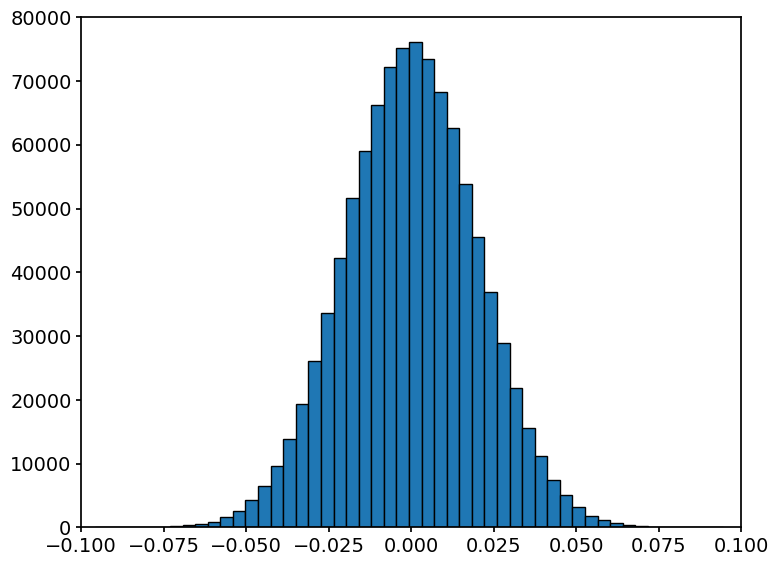

In [7]:
plt.hist(target_data[:,1], bins=50)

In [35]:
# Creating the FFNN model

# Defining the input layer
input = Input(shape=(7,3))
# Flattening the input (by now no convolutional layer - data are already pretty compressed)
hidden = Flatten()(input)
norm = BatchNormalization()(hidden)
# Creating some dense layers - the activation is linear because we are performing a regression
hidden = Dense(200, activation='relu')(norm)
hidden = Dropout(0.1)(hidden)
hidden = Dense(200, activation='relu')(hidden)
hidden = Dense(200, activation='relu')(hidden)
hidden = Dropout(0.05)(hidden)
hidden = Dense(200, activation='relu')(hidden)
hidden = Dropout(0.05)(hidden)
hidden = Dense(200, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
hidden = Dense(100, activation='relu')(hidden)
hidden = Dense(50, activation='relu')(hidden)
# Defining the outputs 

output_energy = Dense(1, activation='linear')(hidden)
output_hit_coordinates = Dense(2, activation='linear')(hidden)
outputs=[output_energy, output_hit_coordinates]
# Defining the loss functions - both MSE for regression
losses = ['MSE', 'MSE']


#output = Dense(3, activation='linear')(hidden)

# Creating the model and compiling it
model = Model(inputs=input, outputs=outputs)

model.compile(loss='MSE', optimizer='adam') # those are standard params, see if any better

# Printing the summary
model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 7, 3)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 21)        │          0 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 21)        │         84 │ flatten_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 200)       │      4,400 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 200)       │          0 │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 200)       │     40,200 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 200)       │     40,200 │ dense_19[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 200)       │          0 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 200)       │     40,200 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 200)       │          0 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 200)       │     40,200 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 100)       │     20,100 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 100)       │     10,100 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 50)        │      5,050 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 1)         │         51 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 2)         │        102 │ dense_25[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 200,687 (783.93 KB)

 Trainable params: 200,645 (783.77 KB)

 Non-trainable params: 42 (168.00 B)

In [90]:
# Defining the path and directory for checkpoints that save the model's weights.
checkpoint_path = "training_1/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)


# By now, we do not save the weights because there are some bugs to be fixed
#history=model.fit(input_data, [target_data[:,0],target_data[:,1:]], epochs=20, validation_split=0.3)  # Pass callback to training

# Create a callback that saves the model's weights
cp_callback = ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)

# Train the model with the new callback
history=model.fit(input_data, [target_data[:,0],target_data[:,1:]], epochs=50, validation_split=0.2, callbacks=[cp_callback])  # Pass callback to training

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

Epoch 1/50
24981/25000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34535.3008
Epoch 1: saving model to training_1/cp.weights.h5
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - loss: 34535.3555 - val_loss: 25107.5352
Epoch 2/50
24991/25000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34663.6523
Epoch 2: saving model to training_1/cp.weights.h5
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - loss: 34663.6523 - val_loss: 27936.0684
Epoch 3/50
24998/25000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34787.9102
Epoch 3: saving model to training_1/cp.weights.h5
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step - loss: 34787.9023 - val_loss: 27058.3789
Epoch 4/50
24987/25000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35342.6250
Epoch 4: saving model to training_1/cp.weights.h5
25000/25000 ━━━━━━━━━━━━━━━━━━━━ 46s 2ms/step - loss: 35342.3711 - val_loss: 26831.1660
Epoch 5/50
24981/25000 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34693.6836
Epoch 5: saving model to training_1/cp.weights.h5
25000/25000 ━━━━━━━━━━━

dict_keys(['loss', 'val_loss'])


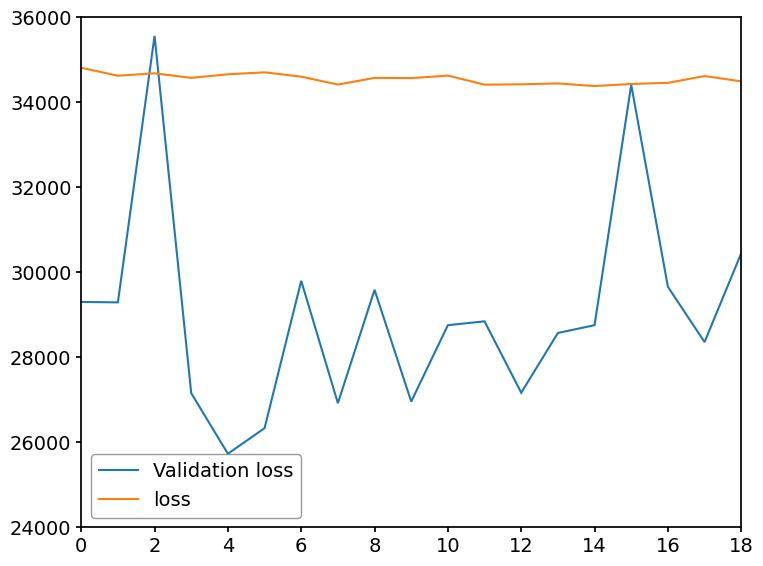

In [79]:
print(history.history.keys())
plt.plot(history.history['val_loss'][1:], label='Validation loss')
plt.plot(history.history['loss'][1:], label='loss')
plt.legend()
plt.show()

In [94]:
# Load the previously saved weights
model.load_weights(checkpoint_path)

In [80]:
new_data = Xraydata('/Users/chiara/hexsampledata/sim_HexagonalLayout.ODD_Rum_0enc_srcsigma200um.h5')

>>> Opening input file /Users/chiara/hexsampledata/sim_HexagonalLayout.ODD_Rum_0enc_srcsigma200um.h5...
>>> File type: FileType.DIGI


In [81]:
# Extrapolating input data and predicting the target using the NN
new_input_data = new_data.input_events_data()
new_target_data = new_data.target_data()
del new_data


100000it [00:03, 29660.16it/s]


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 552us/step


Predicting the data using the NN

In [95]:
predicted_data = model.predict(new_input_data)

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 546us/step


In [96]:
print(new_target_data[:,0])

[8046.3 8046.3 8026.7 ... 8046.3 8026.7 8026.7]


In [97]:
print(predicted_data)

[array([[8077.4814],
       [8077.4814],
       [8124.2886],
       ...,
       [8077.4814],
       [8077.4814],
       [8077.4814]], dtype=float32), array([[-0.4902931 , -0.01575603],
       [-0.4902931 , -0.01575603],
       [-0.49794   , -0.01411463],
       ...,
       [-0.4902931 , -0.01575603],
       [-0.4902931 , -0.01575603],
       [-0.4902931 , -0.01575603]], dtype=float32)]


In [98]:
print(predicted_data[0])

[[8077.4814]
 [8077.4814]
 [8124.2886]
 ...
 [8077.4814]
 [8077.4814]
 [8077.4814]]


(array([7.0703e+04, 1.7688e+04, 1.3980e+03, 1.6620e+03, 5.3600e+02,
        4.8400e+02, 3.1200e+02, 2.5900e+02, 1.4900e+02, 9.6000e+01,
        1.0800e+02, 1.0400e+02, 1.0300e+02, 8.7000e+01, 8.3000e+01,
        6.3000e+01, 6.5000e+01, 5.3000e+01, 2.4900e+02, 5.7980e+03]),
 array([8077.4814, 8118.9946, 8160.5073, 8202.0205, 8243.533 , 8285.047 ,
        8326.56  , 8368.072 , 8409.585 , 8451.099 , 8492.611 , 8534.124 ,
        8575.638 , 8617.15  , 8658.663 , 8700.176 , 8741.689 , 8783.202 ,
        8824.715 , 8866.229 , 8907.741 ], dtype=float32),
 <BarContainer object of 20 artists>)

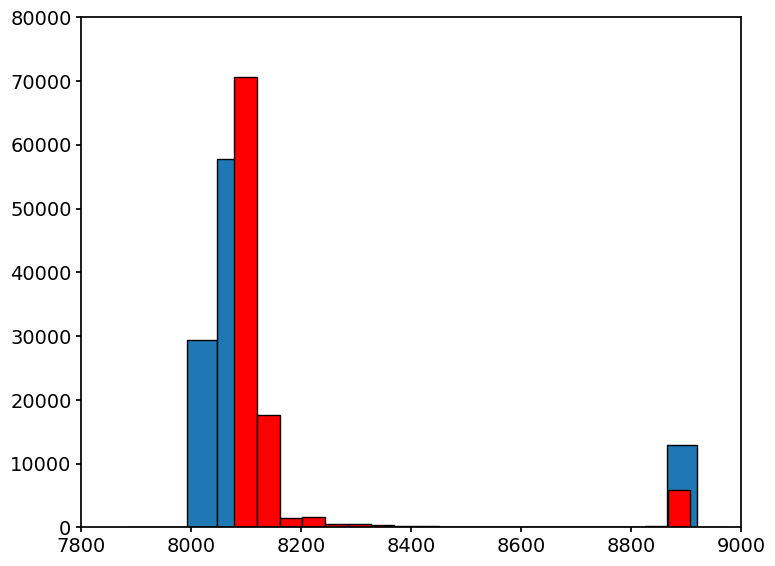

In [99]:
plt.hist(new_target_data[:,0], 20)
plt.hist(predicted_data[0], 20, color='red')

Okay, it is learning something because the shape is fine but there is a shift on the left to be understood. Let's see the positions.

In [100]:
print(predicted_data[1][:,0])

[-0.4902931 -0.4902931 -0.49794   ... -0.4902931 -0.4902931 -0.4902931]


In [101]:
print(new_target_data[:,1])
print(predicted_data[1][:,0])

[-0.00071126 -0.00862364  0.00348964 ...  0.00208249  0.00677484
  0.00246153]
[-0.4902931 -0.4902931 -0.49794   ... -0.4902931 -0.4902931 -0.4902931]


(array([4.2200e+02, 5.1160e+03, 1.8200e+02, 1.2500e+02, 8.5000e+01,
        8.2000e+01, 5.1000e+01, 2.4000e+01, 1.6000e+01, 2.3000e+01,
        2.9000e+01, 2.1000e+01, 2.6000e+01, 2.9000e+01, 2.5000e+01,
        3.8000e+01, 4.5000e+01, 3.1000e+01, 4.5000e+01, 4.2000e+01,
        3.5000e+01, 5.1000e+01, 3.3000e+01, 4.3000e+01, 4.6000e+01,
        4.4000e+01, 4.4000e+01, 3.3000e+01, 3.6000e+01, 5.3000e+01,
        7.6000e+01, 9.3000e+01, 1.0600e+02, 1.1300e+02, 1.2600e+02,
        1.4000e+02, 1.8100e+02, 1.9100e+02, 2.3800e+02, 2.0400e+02,
        2.2300e+02, 1.9400e+02, 1.3890e+03, 1.9000e+02, 4.3000e+02,
        9.8700e+02, 3.9380e+03, 1.3309e+04, 1.6250e+03, 6.9372e+04]),
 array([-0.66819185, -0.66463286, -0.66107386, -0.65751487, -0.6539558 ,
        -0.6503968 , -0.64683783, -0.64327884, -0.63971984, -0.63616085,
        -0.6326018 , -0.6290428 , -0.6254838 , -0.6219248 , -0.6183658 ,
        -0.61480683, -0.6112478 , -0.6076888 , -0.6041298 , -0.6005708 ,
        -0.5970118 , -0.59

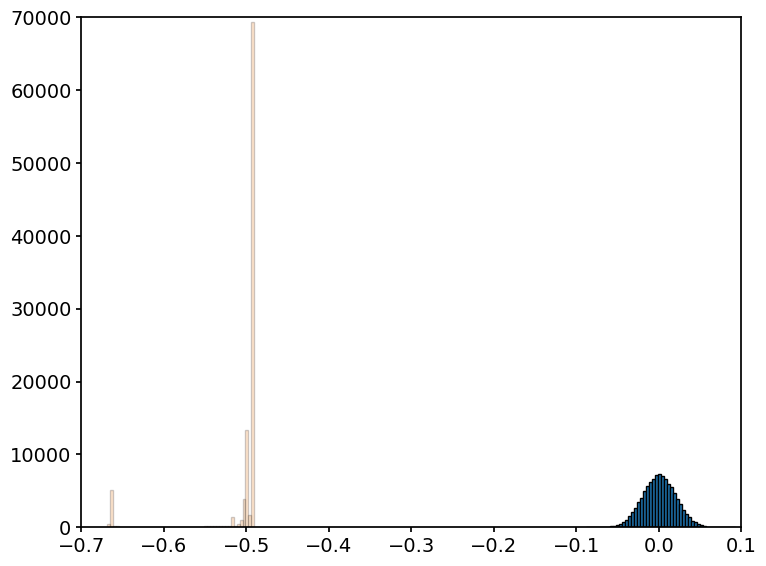

In [102]:
plt.figure()
plt.hist(new_target_data[:,1], 50)
plt.hist(predicted_data[1][:,0], 50, alpha=0.2)

(array([6.9341e+04, 4.7400e+02, 8.0940e+03, 9.8950e+03, 1.1170e+03,
        5.9000e+02, 2.2600e+02, 1.4300e+02, 1.3770e+03, 1.9500e+02,
        2.0900e+02, 1.9100e+02, 2.2000e+02, 1.8100e+02, 1.8500e+02,
        1.4000e+02, 1.1600e+02, 1.1100e+02, 1.0600e+02, 9.3000e+01,
        8.9000e+01, 5.5000e+01, 4.2000e+01, 3.2000e+01, 4.1000e+01,
        3.6000e+01, 4.5000e+01, 4.1000e+01, 3.9000e+01, 3.2000e+01,
        4.6000e+01, 3.5000e+01, 4.3000e+01, 3.7000e+01, 3.6000e+01,
        3.1000e+01, 3.9000e+01, 3.6000e+01, 2.1000e+01, 2.7000e+01,
        2.2000e+01, 2.3000e+01, 2.7000e+01, 2.1000e+01, 1.4000e+01,
        2.2000e+01, 7.7000e+01, 6.0700e+02, 3.9640e+03, 1.4160e+03]),
 array([-1.58110708e-02, -1.51489424e-02, -1.44868139e-02, -1.38246855e-02,
        -1.31625570e-02, -1.25004295e-02, -1.18383011e-02, -1.11761726e-02,
        -1.05140442e-02, -9.85191576e-03, -9.18978732e-03, -8.52765888e-03,
        -7.86553044e-03, -7.20340246e-03, -6.54127402e-03, -5.87914605e-03,
        -5.217

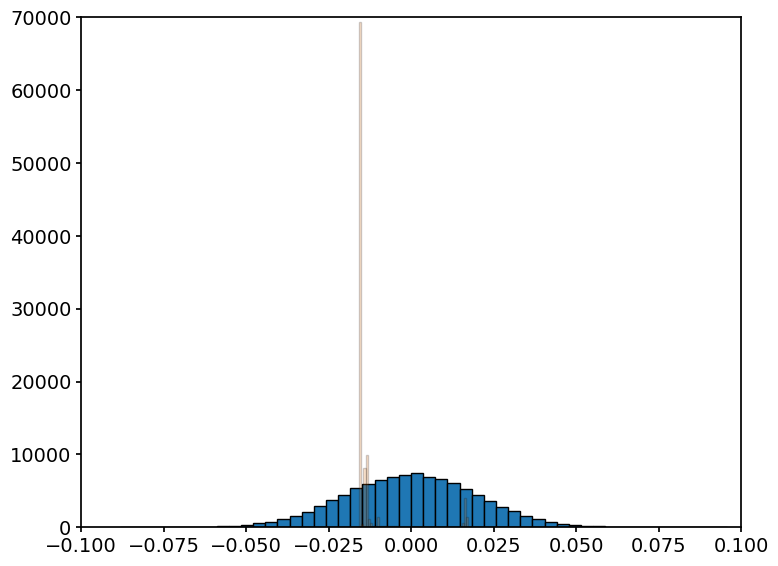

In [105]:
plt.figure()
plt.hist(new_target_data[:,2], 50)
plt.hist(predicted_data[1][:,1], 50, alpha=0.2)

My doubt (besides the fact that previsions are not reasonable) is that the NN is not learning the shape of the x and y distribution, instead is learning something that looks like the bimodal shape of the energy.